Dataset citation: Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2

http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

### [Package load]

In [2]:
import torch
print('pytorch version: {}'.format(torch.__version__))

pytorch version: 2.2.2


In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 2.2.2
GPU 사용 가능 여부: False


In [4]:
# 이걸 해줘야 matplotlib 시행 시 에러가 안 남
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### [For Colab]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path

folder = "인공지능 공부" # 상위 directory
project_dir = "[Kaggle] Retinal OCT Images (optical coherence tomography)제목없는 폴더" # 폴더 이름
base_path = Path("/content/drive/MyDrive/")
project_path = base_path / folder / project_dir

os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

### [Setting Hyperparameters]

In [5]:
batch_size = 64
num_epochs = 30
learning_rate = 0.001

### [Dataset & DataLoader]

- ##### 1 channel -> (1,224,224)

In [ ]:
data_dir = '../data/OCT'  # 압축 해제된 데이터셋의 디렉토리 경로

# For Kaggle notebook
#data_dir = '/kaggle/input/kermany2018/OCT2017 /'

In [ ]:
class OCTDataset(Dataset):
    def __init__(self, data_dir, mode, transform=None):
        self.all_data = sorted(glob.glob(os.path.join(data_dir, mode,'*', '*')))
        self.transform = transform
    
    def __getitem__(self, index):
        data_path = self.all_data[index]
        img = Image.open(data_path)
        if self.transform is not None:
            img = self.transform(img)
        name = os.path.basename(data_path)
        if name.startswith('NORMAL'):
            label = 0
        elif name.startswith('CNV'):
            label = 1
        elif name.startswith('DME'):
            label = 2
        elif name.startswith('DRUSEN'):
            label = 3
        return img, label
    
    def __len__(self):
        length = len(self.all_data)
        return length

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(0.1881,0.1850)
    ]),
    'val': transforms.Compose([
        transforms.Resize([256]),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(0.1881,0.1850)
    ])
}

In [ ]:
train_data = OCTDataset(data_dir=data_dir, mode='train', transform=data_transforms['train'])
val_data = OCTDataset(data_dir=data_dir, mode='val', transform=data_transforms['val'])
test_data = OCTDataset(data_dir=data_dir, mode='test', transform=data_transforms['val'])

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False)

In [ ]:
# Calculating mean and std of training data set
full_loader = DataLoader(train_data, shuffle=False) #num_workers=os.cpu_count())
mean = torch.zeros(1)
std = torch.zeros(1)
for inputs, _ in tqdm(full_loader):
    mean += inputs.mean()
    std += inputs.std()
mean /= len(train_data)
std /= len(train_data)
print(f"train mean: {mean}, train std: {std}")

  0%|          | 0/83484 [00:00<?, ?it/s]

train mean: tensor([0.1881]), train std: tensor([0.1850])


In [ ]:
train_mean = 0.1881
train_std = 0.1850

- ##### 3 channel: Input을 3번 concat -> (3,224,224)

In [6]:
data_dir = '../data/OCT'  # 압축 해제된 데이터셋의 디렉토리 경로

# For Kaggle notebook
#data_dir = '/kaggle/input/kermany2018/OCT2017 /'

In [7]:
class OCTDataset(Dataset):
    def __init__(self, data_dir, mode, transform=None):
        self.all_data = sorted(glob.glob(os.path.join(data_dir, mode,'*', '*')))
        self.transform = transform
    
    def __getitem__(self, index):
        data_path = self.all_data[index]
        img = Image.open(data_path)
        if self.transform is not None:
            img = self.transform(img)
        img = img.squeeze()
        img = torch.stack((img, img, img,), dim=0)  # VGG16이 3 channel이라 concat시키기
        name = os.path.basename(data_path)
        if name.startswith('NORMAL'):
            label = 0
        elif name.startswith('CNV'):
            label = 1
        elif name.startswith('DME'):
            label = 2
        elif name.startswith('DRUSEN'):
            label = 3
        return img, label
    
    def __len__(self):
        length = len(self.all_data)
        return length

In [51]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomResizedCrop(299, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(0.1881,0.1850)
    ]),
    'val': transforms.Compose([
        transforms.Resize([256]),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(0.1881,0.1850)
    ])
}
# Inception v3는 (3,299,299)를 사용함

In [52]:
train_data = OCTDataset(data_dir=data_dir, mode='train', transform=data_transforms['train'])
val_data = OCTDataset(data_dir=data_dir, mode='val', transform=data_transforms['val'])
test_data = OCTDataset(data_dir=data_dir, mode='test', transform=data_transforms['val'])

In [53]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False)

In [54]:
train_mean = 0.1881
train_std = 0.1850

### [Model: Inception v3]

- https://github.com/pytorch/vision/blob/main/torchvision/models/googlenet.py
- https://velog.io/@krec7748/Inception-Net-v2-v3

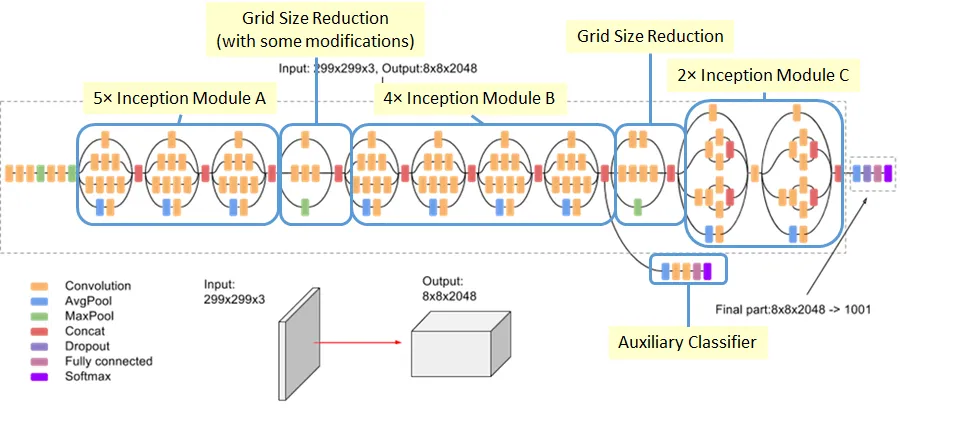

In [55]:
class InceptionA(nn.Module):    # Figure 5에 해당, Inception module A
    def __init__(self, in_channels, pool_features, conv_block=None):
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        
        self.branch1x1 = conv_block(in_channels, 64, kernel_size=1)

        self.branch3x3_1 = conv_block(in_channels, 48, kernel_size=1)
        self.branch3x3_2 = conv_block(48, 64, kernel_size=3, padding=1)     # pytorch github에는 5x5로 되어 있어서 3x3으로 수정

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, padding=1)

        self.branch_pool = conv_block(in_channels, pool_features, kernel_size=1)

    def _forward(self, x):  # output이 list
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionB(nn.Module):    # 3x3으로 Grid size reduction하는 module
    def __init__(self, in_channels, conv_block = None):
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3 = conv_block(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, stride=2)

    def _forward(self, x):  # output이 list
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionC(nn.Module):    # 1x7, 7x1로 factorization하는 파트 (Figure 6) Inception module B
    def __init__(self, in_channels, channels_7x7, conv_block = None):
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = conv_block(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = conv_block(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def _forward(self, x):  # output이 list
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionD(nn.Module):    # Figure 10 : conv (stride 2) -> pooling operation
    def __init__(self, in_channels, conv_block = None):
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = conv_block(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = conv_block(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = conv_block(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = conv_block(192, 192, kernel_size=3, stride=2)

    def _forward(self, x):  # output이 list
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionE(nn.Module):    # Figure 7에 해당. Inception module C
    def __init__(self, in_channels, conv_block = None):
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = conv_block(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = conv_block(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def _forward(self, x):  # output이 list
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):  # Auxillary classifier
    def __init__(self, in_channels, num_classes, conv_block = None):
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.conv0 = conv_block(in_channels, 128, kernel_size=1)
        self.conv1 = conv_block(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01  # type: ignore[assignment]
        self.fc = nn.Linear(768, num_classes)
        self.fc.stddev = 0.001  # type: ignore[assignment]

    def forward(self, x):
        # N x 768 x 17 x 17
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # N x 768 x 5 x 5
        x = self.conv0(x)
        # N x 128 x 5 x 5
        x = self.conv1(x)
        # N x 768 x 1 x 1
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 768 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 768
        x = self.fc(x)
        # N x 1000
        return x


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


from collections import namedtuple
InceptionOutputs = namedtuple("InceptionOutputs", ["logits", "aux_logits"])

class InceptionV3(nn.Module):
    def __init__(self, num_classes, aux_logits= True, inception_blocks=None, dropout=0.5):
        super().__init__()
        if inception_blocks is None:
            inception_blocks = [BasicConv2d, InceptionA, InceptionB, InceptionC, InceptionD, InceptionE, InceptionAux]
        if len(inception_blocks) != 7:
            raise ValueError(f"length of inception_blocks should be 7 instead of {len(inception_blocks)}")
        
        conv_block = inception_blocks[0]
        inception_a = inception_blocks[1]   # Fig 5, Inception module A
        inception_b = inception_blocks[2]   # Grid 축소
        inception_c = inception_blocks[3]   # Fig 6, Inception module B
        inception_d = inception_blocks[4]   # Fig 10, Grid 축소
        inception_e = inception_blocks[5]   # Fig 7, Inception module C
        inception_aux = inception_blocks[6] # Auxilary classifier

        self.aux_logits = aux_logits
        self.Conv2d_1a_3x3 = conv_block(3, 32, kernel_size=3, stride=2)     # ( 3, 299, 299) -> (32, 149, 149)
        self.Conv2d_2a_3x3 = conv_block(32, 32, kernel_size=3)              # (32, 149, 149) -> (32, 147, 147)
        self.Conv2d_2b_3x3 = conv_block(32, 64, kernel_size=3, padding=1)   # (32, 147, 147) -> (64, 147, 147)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)               # (64, 147, 147) -> (64,  73,  73)
        self.Conv2d_3b_1x1 = conv_block(64, 80, kernel_size=1)              # (64,  73,  73) -> (80,  73,  73)
        self.Conv2d_4a_3x3 = conv_block(80, 192, kernel_size=3)             # (80,  73,  73) -> (192, 71,  71)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)               # (192, 71,  71) -> (192, 35,  35)
        
        # InceptionA(in_channels, pool_features, conv_block=None): Fig 5, Inception module A
        self.Mixed_5b = inception_a(192, pool_features=32)  # output channel = 64 + 64 + 96 + pool_fatures = 256
                                                            # (192, 35, 35) -> (256, 35, 35)
        self.Mixed_5c = inception_a(256, pool_features=64)  # (256, 35, 35) -> (256, 35, 35)
        self.Mixed_5d = inception_a(288, pool_features=64)  # (256, 35, 35) -> (288, 35, 35)

        # InceptionB(in_channels, conv_block = None): Grid 축소
        self.Mixed_6a = inception_b(288)                    # output channel = 384 + 96 + 288 = 768
                                                            # (288, 35, 35) -> (768, 17, 17)
        
        # InceptionC(in_channels, channels_7x7, conv_block = None): Fig 6, Inception module B
        self.Mixed_6b = inception_c(768, channels_7x7=128)  # (768, 17, 17) -> (768, 17, 17) channels_7x7만 계속 달라짐
        self.Mixed_6c = inception_c(768, channels_7x7=160)  # (768, 17, 17) -> (768, 17, 17)
        self.Mixed_6d = inception_c(768, channels_7x7=160)  # (768, 17, 17) -> (768, 17, 17)
        self.Mixed_6e = inception_c(768, channels_7x7=192)  # (768, 17, 17) -> (768, 17, 17)

        # InceptionAux(in_channels, num_classes, conv_block = None): Auxilary classifier
        self.AuxLogits = None
        if aux_logits:
            self.AuxLogits = inception_aux(768, num_classes)
        
        # InceptionD(in_channels, conv_block = None): Fig 10, Grid 축소
        self.Mixed_7a = inception_d(768)

        # InceptionE(in_channels, conv_block = None): Fig 7, Inception module C
        self.Mixed_7b = inception_e(1280)
        self.Mixed_7c = inception_e(2048)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(2048, num_classes)

    def _forward(self, x):
        # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.maxpool2(x)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        aux = None
        if self.AuxLogits is not None:
            if self.training:
                aux = self.AuxLogits(x)
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = self.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.dropout(x)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 2048
        x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux

    def forward(self, x):
        x, aux = self._forward(x)
        return InceptionOutputs(x, aux)

In [56]:
inception_v3 = InceptionV3(num_classes=4).to(device)

In [57]:
inception_v3

InceptionV3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), str

In [59]:
temp = torch.Tensor(np.random.randint(1, 255, size=(2, 3, 299, 299)))
print(inception_v3(temp))

InceptionOutputs(logits=tensor([[-0.2163, -0.0754,  0.3572,  0.1165],
        [-0.2836,  0.3130,  0.3749,  0.1114]], grad_fn=<AddmmBackward0>), aux_logits=tensor([[ 0.4885, -0.1306, -0.0032,  0.0319],
        [ 0.7105, -0.1515, -1.0155, -0.5032]], grad_fn=<AddmmBackward0>))


In [42]:
from torchsummary import summary
summary(inception_v3, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [43]:
from torchinfo import summary
summary(inception_v3, input_size=(1, 3, 299, 299), col_width=20, depth=121, row_settings=["depth", "var_names"], col_names=["input_size", "kernel_size", "output_size", "params_percent"])

Layer (type (var_name):depth-idx)                  Input Shape          Kernel Shape         Output Shape         Param %
InceptionV3 (InceptionV3)                          [1, 3, 299, 299]     --                   [1, 4]                10.58%
├─BasicConv2d (Conv2d_1a_3x3): 1-1                 [1, 3, 299, 299]     --                   [1, 32, 149, 149]         --
│    └─Conv2d (conv): 2-1                          [1, 3, 299, 299]     [3, 3]               [1, 32, 149, 149]      0.00%
│    └─BatchNorm2d (bn): 2-2                       [1, 32, 149, 149]    --                   [1, 32, 149, 149]      0.00%
├─BasicConv2d (Conv2d_2a_3x3): 1-2                 [1, 32, 149, 149]    --                   [1, 32, 147, 147]         --
│    └─Conv2d (conv): 2-3                          [1, 32, 149, 149]    [3, 3]               [1, 32, 147, 147]      0.04%
│    └─BatchNorm2d (bn): 2-4                       [1, 32, 147, 147]    --                   [1, 32, 147, 147]      0.00%
├─BasicConv2d (Conv2d_2b

### [Saving checkpoints]

In [44]:
def save_model(model, epoch, optimizer, epoch_loss, val_accuracy, saved_dir):
    os.makedirs(saved_dir, exist_ok=True)
    check_point = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss
    }
    val_accuracy = round(val_accuracy,1)
    file_name = str(f"ckpoint_{epoch+1}_{val_accuracy}%.pt")
    output_path = os.path.join(saved_dir, file_name)
    torch.save(check_point,output_path)

### [Loss tracker]

##### Visdom for local setting

In [ ]:
import visdom

vis = visdom.Visdom()
vis.close(env="main")

Setting up a new session...


''

In [ ]:
def loss_tracker(loss_plot, loss_value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=loss_value,
             win = loss_plot,
             update='append'
             )

In [ ]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))

##### Tensorboard

In [29]:
logs_base_dir = "./logs/logs_simple"
os.makedirs(logs_base_dir, exist_ok=True)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(logs_base_dir)

### [Defining Train, Val, Test Function]

In [45]:
def train(num_epochs, model, data_loader, criterion, optimizer, scheduler, val_every, device, saved_dir, writer):
    print('Start training..')
    torch.cuda.empty_cache()
    best_loss = 9999999
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    for epoch in tqdm(range(num_epochs), desc='epoch'):
        count = 0
        # running_loss = 0.0
        for i, (imgs, labels) in tqdm(enumerate(data_loader), desc="in epoch"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs, aux = model(imgs)       # 여기서 inception net의 특징이 나옴
            output_loss = criterion(outputs, labels)
            aux_loss = criterion(aux, labels)
            loss = output_loss + 0.3*aux_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Saving train loss
            train_loss_list.append(loss.item())

            _, argmax = torch.max(outputs, 1)
            accuracy = (labels == argmax).float().mean()
            # Saving train accuracy
            train_accuracy_list.append(accuracy)

            if (i+1) % 30 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                    epoch+1, num_epochs, i+1, len(data_loader), loss.item(), accuracy.item() * 100))
            if (i+1) % 50 == 0:
                writer.add_scalar('Loss/Train', loss, i)
                writer.add_scalar('Accuracy/Train', accuracy, i)
            #if i % 30 == 29:
                #loss_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
                #running_loss = 0.0
        if (epoch + 1) % val_every == 0:
            avrg_loss, val_accuracy = validation(epoch + 1, model, val_loader, criterion, device)
            # Saving validation loss and accuracy
            val_loss_list.append(avrg_loss)
            writer.add_scalar('Loss/Validation', avrg_loss, epoch+1)
            val_accuracy_list.append(val_accuracy)
            writer.add_scalar('Accuracy/Validation', val_accuracy, epoch+1)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, epoch, optimizer, avrg_loss, val_accuracy, saved_dir)
                count = 0
            else:
                count += 1
                if count >= 10:
                    print('Best performance does not occur within 10 epochs. Early stopping!!')
                    scheduler.step()
                    writer.flush()
                    return train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list
            ''' Only for local setting
            loss_tracker(loss_plt, torch.Tensor([avrg_loss]), torch.Tensor([epoch]))'''
    scheduler.step()
    writer.flush()
    return train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list

In [46]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch) )
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        cnt = 0
        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)       # eval을 했기 때문에 aux가 필요 없음
            loss = criterion(outputs, labels)
            
            total += imgs.size(0)
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item()
            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        val_accuracy = correct / total * 100
        print('Validation #{}  Accuracy: {:.2f}%  Average Loss: {:.4f}'.format(epoch, val_accuracy, avrg_loss))
    model.train()
    return avrg_loss, val_accuracy

In [47]:
def test(model, data_loader, device):
    print('Start test..')
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        answer_list = []
        pred_list = []
        pred_proba_list = []
        
        for i, (imgs, labels) in tqdm(enumerate(data_loader)):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)       # 여기도 eval을 하기 때문에 aux가 필요 없음
            
            pred_probability = F.softmax(outputs, dim=1)
            pred_proba_list.append(pred_probability.tolist())
            
            _, argmax = torch.max(outputs, 1)
            pred_list.append(argmax.tolist())

            total += imgs.size(0)
            correct += (labels == argmax).sum().item()
            
            answer_list.append(labels.tolist())
        
        print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))
    model.train()        
    return pred_list, answer_list, pred_proba_list

### [Loss function, Optimizer, Directory for saving]

In [60]:
torch.manual_seed(7777)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(inception_v3.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.00001)

val_every = 1
saved_dir = './saved'

### [Train]

In [ ]:
train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list = train(num_epochs, inception_v3, train_loader, criterion, optimizer, scheduler, val_every, device, saved_dir, writer)

##### Visualizing train loss and accuracy

- With matplotlib in colab setting

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.ylabel('Loss')
plt.plot(train_loss_list, label = 'Train')
plt.plot(val_loss_list, label = 'Validation')
plt.subplot(1,2,2)
plt.ylabel('Accuracy')
plt.plot(train_accuracy_list, label = 'Train')
plt.plot(val_accuracy_list, label = 'Validation')
# plt.savefig('graph.png',facecolor = 'w')
plt.show()

- With Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir='./logs/logs_simple'

### [Test]

##### Loading best model

In [ ]:
inception_v3_test = InceptionV3().to(device) 
model_path = './saved/.pt'    # .pt 앞에 파일 이름 붙이기
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint['model_state_dict']
inception_v3_test.load_state_dict(state_dict)
inception_v3_test.eval()

##### Actual test

In [ ]:
with torch.no_grad():
    pred_list, answer_list, pred_proba_list = test(inception_v3_test, test_loader, device)